<a href="https://www.kaggle.com/code/mustafacihadgoktepe/chest-x-ray-images-pneumonia?scriptVersionId=140663200" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In this notebook, we will explore the application of deep learning for the detection of pneumonia in chest X-ray images. Pneumonia is a common and potentially life-threatening respiratory infection that requires timely diagnosis and treatment. Chest X-rays are a valuable diagnostic tool for identifying lung abnormalities, including pneumonia.

The objective of this project is to build a deep learning model capable of accurately classifying chest X-ray images into two categories: normal and pneumonia-affected. This binary classification task has significant clinical relevance, as it can aid healthcare professionals in identifying cases of pneumonia more efficiently.

We will follow these key steps throughout the notebook:

1. **Data Preprocessing**: We will prepare the dataset, including data augmentation and normalization, to ensure it's suitable for training deep learning models.

2. **Model Architecture**: We will design a convolutional neural network (CNN) architecture for image classification. CNNs are well-suited for tasks like image classification due to their ability to capture spatial features.

3. **Model Training**: We will train the CNN model on a labeled dataset of chest X-ray images. We will implement techniques like early stopping and learning rate scheduling to monitor and improve the training process.

4. **Evaluation Metrics**: We will evaluate the model using various metrics, including accuracy, precision, recall, AUC-ROC, and loss, to gain insights into its performance.

5. **Results Analysis**: We will analyze the model's predictions and discuss the clinical implications of its performance.

6. **Conclusion**: We will summarize the findings, discuss potential areas for improvement, and reflect on the significance of this work in the context of pneumonia detection.

By the end of this notebook, you will have a well-trained deep learning model for pneumonia detection, along with insights into its performance and practical applications in the field of healthcare.

Let's get started!


## Data Preparation and Exploration

In this section, we'll set up the data pipeline and explore the dataset to gain a better understanding of the chest X-ray images used for pneumonia detection.

### Importing Libraries

We begin by importing essential libraries for data manipulation, visualization, and deep learning:

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Loading and Preprocessing Data

We'll load the chest X-ray image data, perform data preprocessing, and set up data generators for training, validation, and testing:

In [2]:
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/'

train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary')

val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/'

val_datagen = ImageDataGenerator(rescale=1/255)

val_generator =  val_datagen.flow_from_directory(val_dir,
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 target_size=(150, 150))

test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/'

test_datagen = ImageDataGenerator(rescale=1/255)

test_generator =  test_datagen.flow_from_directory(test_dir,
                                                   batch_size=32,
                                                   class_mode='binary',
                                                   target_size=(150, 150))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
train_generator[0][0].shape

(32, 150, 150, 3)

In [9]:
# Display the number of images and classes in the training, validation, and test sets
print("Training Dataset:")
print(train_generator.n, "images belonging to", len(train_generator.class_indices), "classes.")

print("\nValidation Dataset:")
print(val_generator.n, "images belonging to", len(val_generator.class_indices), "classes.")

print("\nTest Dataset:")
print(test_generator.n, "images belonging to", len(test_generator.class_indices), "classes.")

# Display the class indices mapping
print("\nClass Indices Mapping:")
print(train_generator.class_indices)

# Display the shape of image
print("\nShape of an Image:")
print(train_generator[0][0][0].shape)

Training Dataset:
5216 images belonging to 2 classes.

Validation Dataset:
16 images belonging to 2 classes.

Test Dataset:
624 images belonging to 2 classes.

Class Indices Mapping:
{'NORMAL': 0, 'PNEUMONIA': 1}

Shape of an Image:
(150, 150, 3)


In [10]:
train_generator[0][1].shape

(32,)

In [11]:
train_generator[0][1][0] # label

1.0

## Data Exploration and Visualization

In this section, we'll explore the dataset and visualize some of the chest X-ray images. Understanding the data can provide valuable insights and help in model development and evaluation.

### Visualizing Sample Images

Let's start by visualizing a few sample images from the training dataset. We'll display both a randomly selected image from the generator and a specific image from the dataset.

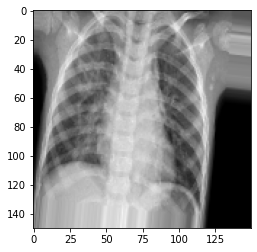

In [12]:
plt.imshow(train_generator[0][0][0]);

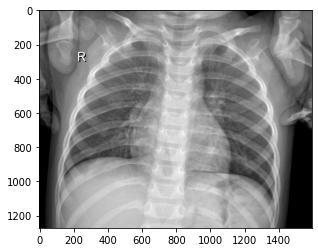

In [13]:
img_dir ='/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0219-0001.jpeg'

plt.imshow(plt.imread(img_dir), cmap='gray');

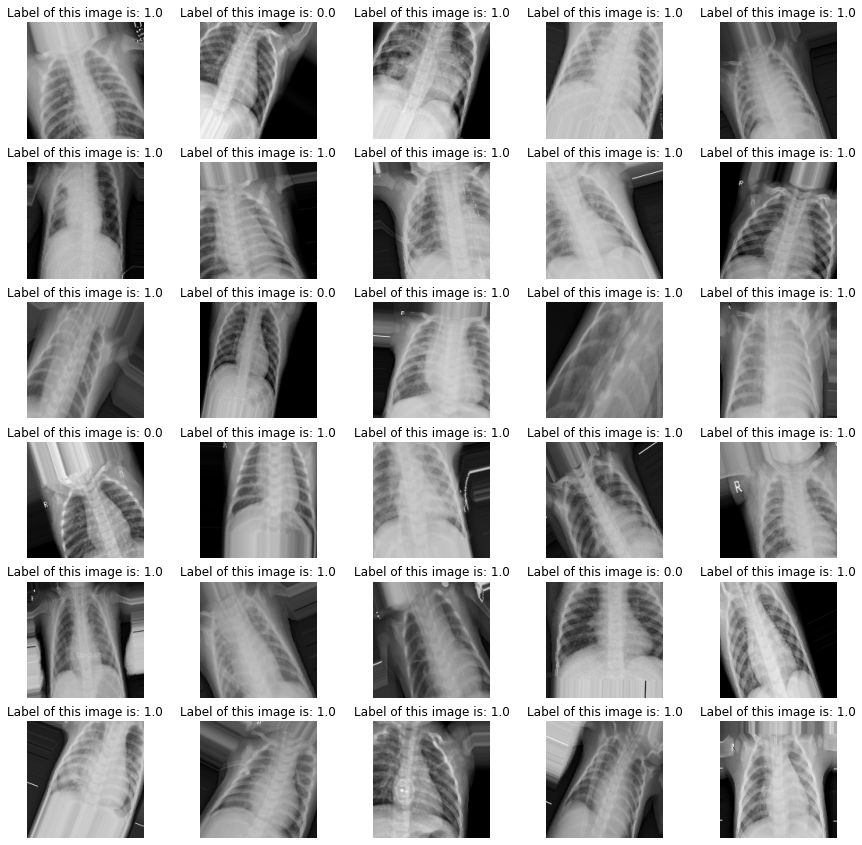

In [14]:
plt.figure(figsize=(15,15))
plt.tight_layout()

data = train_generator.next()
# image = data[0]
# label =data[1]

for i in range(30):
    plt.subplot(6,5,i+1)
    plt.axis('off')
    plt.title('Label of this image is: ' + str(data[1][i]))
    plt.imshow(data[0][i], cmap='gray')

## Data Class Distribution and Class Weights

Understanding the distribution of classes in a dataset is crucial for building and training machine learning models, especially when dealing with imbalanced datasets. In this section, we'll explore the class distribution of the chest X-ray dataset and compute class weights to address potential class imbalances.

In [16]:
from collections import Counter

counter = Counter(train_generator.classes)
counter

Counter({0: 1341, 1: 3875})

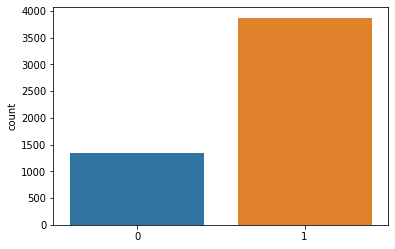

In [18]:
sns.countplot(train_generator.classes);

The count plot provides a visual representation of the balance (or imbalance) between the two classes. Understanding class distribution is essential for making informed decisions during model training.

### Computing Class Weights

To account for class imbalance during model training, we can compute class weights. Class weights assign higher importance to underrepresented classes, helping the model give more attention to minority classes.

In [19]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes = np.unique(train_generator.classes),
                                                  y = train_generator.classes)

class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

The computed class weights show how much weight each class should receive during training. In this context, a higher weight is assigned to 'NORMAL' (0) because it is the minority class, while a lower weight is assigned to 'PNEUMONIA' (1). These class weights help balance the model's learning process, particularly when dealing with imbalanced datasets.

Understanding class distribution and applying appropriate class weights are crucial steps in handling imbalanced data and training a robust machine learning model.

## Model Architecture Definition and Compilation

In this section, we define the architecture of our deep learning model for chest X-ray image classification. We then compile the model, specifying the optimizer, loss function, and evaluation metrics. Additionally, we set up early stopping and learning rate scheduling callbacks to monitor and optimize the training process.

Our model comprises convolutional layers for feature extraction, max-pooling layers for down-sampling, batch normalization to stabilize training, and dropout layers to prevent overfitting. The final layer is a dense layer with a sigmoid activation function for binary classification.

### Callbacks

To optimize training and prevent overfitting, we employ two callbacks:

*   Early Stopping: Monitors validation loss and stops training if it doesn't improve for 10 consecutive epochs. It restores the best weights.
*   Learning Rate Scheduler: Adjusts the learning rate if validation loss doesn't improve for 2 consecutive epochs.

In [20]:
from tensorflow.keras import Sequential, layers, callbacks, metrics, optimizers, losses

model = Sequential([
    layers.BatchNormalization(input_shape=(150, 150, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Conv2D(128, (5,5), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
]) 

model.compile(optimizer=optimizers.Adam(),
              loss=losses.BinaryCrossentropy(),
              metrics=[metrics.BinaryAccuracy(),
                       metrics.AUC(),
                       metrics.Precision(),
                       metrics.Recall()])
              
early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)

lr_sch = callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience= 2, factor = np.sqrt(0.2), verbose = 1,
                                     min_lr = 5e-10)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 150, 150, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 74, 74, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0

## Model Training

In this section, we commence the training of our deep learning model using the training dataset. We'll specify various training parameters, including the number of training epochs, class weights, and callbacks for monitoring and optimizing the training process.

### Training the Model

To train the model, we use the `fit` method and provide the following parameters:

In [21]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    epochs=100,
    class_weight = class_weights,
    callbacks=[early_stopping, lr_sch]
)

Epoch 1/100
163/163 [==============================] - 136s 762ms/step - loss: 0.3929 - binary_accuracy: 0.8213 - auc: 0.9132 - precision: 0.9518 - recall: 0.8000 - val_loss: 2.9406 - val_binary_accuracy: 0.5000 - val_auc: 0.6250 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/100
163/163 [==============================] - 88s 541ms/step - loss: 0.2832 - binary_accuracy: 0.8790 - auc: 0.9510 - precision: 0.9664 - recall: 0.8674 - val_loss: 2.7564 - val_binary_accuracy: 0.5000 - val_auc: 0.6875 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/100
163/163 [==============================] - 89s 546ms/step - loss: 0.2728 - binary_accuracy: 0.8911 - auc: 0.9542 - precision: 0.9636 - recall: 0.8870 - val_loss: 2.5668 - val_binary_accuracy: 0.5625 - val_auc: 0.6641 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 4/100
163/163 [==============================] - 89s 545ms/step - loss: 0.2351 - binary_accuracy: 0.8988 - auc: 0.9655 - precision: 0.9739 - recall: 0.8875 - val_loss: 0.5

## Training Progress Visualization

In this section, we'll visualize the training progress by plotting the loss and accuracy curves. These visualizations provide valuable insights into how well our model is learning from the data and whether it's converging effectively.

### Creating a DataFrame from Training History

First, we create a DataFrame to organize and analyze the training history:

In [22]:
history_df = pd.DataFrame(history.history)
history_df

,loss,binary_accuracy,auc,precision,recall,val_loss,val_binary_accuracy,val_auc,val_precision,val_recall,lr
0,0.392929,0.821319,0.913181,0.951796,0.800000,2.940555,0.5000,0.625000,0.500000,1.000,0.001000
1,0.283195,0.879026,0.950953,0.966360,0.867355,2.756383,0.5000,0.687500,0.500000,1.000,0.001000
2,0.272752,0.891104,0.954205,0.963555,0.886968,2.566825,0.5625,0.664062,0.533333,1.000,0.001000
3,0.235094,0.898773,0.965540,0.973945,0.887484,0.527491,0.6875,0.906250,1.000000,0.375,0.001000
4,0.230464,0.905100,0.966952,0.971277,0.898839,2.535318,0.5625,0.492188,1.000000,0.125,0.001000
5,0.224545,0.910659,0.967189,0.975453,0.902452,0.701590,0.6875,0.687500,0.666667,0.750,0.001000
6,0.203090,0.915644,0.973082,0.975630,0.909161,0.539825,0.6875,0.796875,0.714286,0.625,0.000447
7,0.177473,0.930406,0.979303,0.980044,0.925161,0.493024,0.6875,0.890625,0.636364,0.875,0.000447
8,0.184039,0.918903,0.978704,0.976796,0.912516,0.557061,0.6875,0.773438,0.666667,0.750,0.000447
9,0.183805,0.928489,0.978040,0.978415,0.924129,1.186081,0.5625,0.773438,0.533333,1.000,0.000447


### Loss and Accuracy Curve

The loss curve helps us assess whether the model is converging and whether there is any sign of overfitting or underfitting. A decreasing training loss and a similar trend in the validation loss indicate successful training.

The accuracy curve provides insights into how well the model is performing in terms of correctly classifying data points. It's important to monitor both the training and validation accuracy to gauge the model's generalization capability.

By examining these curves, we can make informed decisions about training hyperparameters, such as the number of epochs and the model architecture, and ensure that the model is learning effectively from the data.

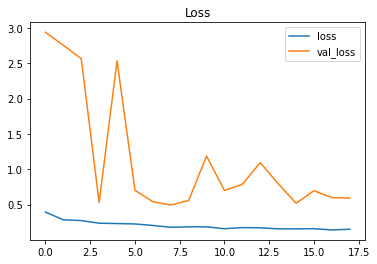

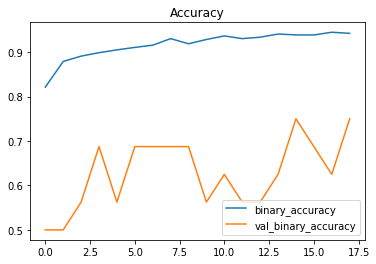

In [23]:
history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss");
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy");


## Model Evaluation on Test Data

In this section, we assess the performance of our trained deep learning model using the test dataset. We'll compute various evaluation metrics and make predictions on unseen data.

### Model Evaluation

Let's begin by evaluating the model on the test dataset and obtaining performance metrics, including loss, accuracy, AUC, precision, and recall:

In [24]:
model.evaluate(test_generator)

20/20 [==============================] - 10s 509ms/step - loss: 0.2834 - binary_accuracy: 0.8830 - auc: 0.9550 - precision: 0.9227 - recall: 0.8872


[0.2834025025367737,
 0.8830128312110901,
 0.9550405740737915,
 0.9226666688919067,
 0.8871794939041138]

### Making Predictions

Next, we make predictions using the trained model on the test dataset. Predictions are made for each data point, and we apply a threshold of 0.5 to classify the predictions into the two classes:

In [38]:
preds = model.predict(test_generator)
preds[preds <= 0.5] = 0
preds[preds > 0.5] = 1
pd.DataFrame(preds, columns=['Predictions'])

,Predictions
0,1.0
1,0.0
2,1.0
3,1.0
4,0.0
...,...
619,1.0
620,1.0
621,1.0
622,1.0


In [25]:
print("\nClass Indices Mapping for Test:")
print(test_generator.class_indices)


Class Indices Mapping for Test:
{'NORMAL': 0, 'PNEUMONIA': 1}


### Single Test Example

As a demonstration, let's make a prediction for a single test example. We'll load an image from the training dataset, preprocess it, and obtain the model's prediction:

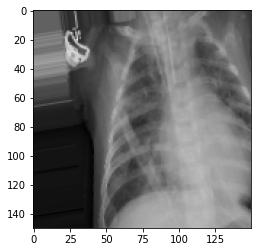

In [54]:
plt.imshow(train_generator[1][0][1]);

In [56]:
test = train_generator[1][0][1]
test = np.expand_dims(test, axis = 0)
pred_ = model.predict(test)
pred_

array([[0.99351877]], dtype=float32)

## Conclusion

In this notebook, we embarked on a journey to develop and evaluate a deep learning model for chest X-ray image classification, specifically detecting pneumonia. We covered various aspects of the model development process, including data preprocessing, model architecture design, training, and evaluation.

Here are the key takeaways from our exploration:

- **Data Preprocessing**: We used image data generators to preprocess and augment the dataset. Data augmentation techniques such as rotation, shifting, shearing, and zooming were applied to increase the model's robustness.

- **Class Distribution**: We examined the distribution of classes in the dataset and computed class weights to address class imbalance. Proper handling of class imbalance is crucial for training a balanced model.

- **Model Architecture**: Our deep learning model was designed with convolutional layers for feature extraction, max-pooling for down-sampling, batch normalization for stability, and dropout layers to prevent overfitting.

- **Training and Monitoring**: We trained the model using the training dataset and monitored its performance on the validation set. Early stopping and learning rate scheduling were employed to optimize the training process.

- **Evaluation and Predictions**: The model's performance was evaluated on the test dataset, yielding metrics such as loss, accuracy, precision, recall, and AUC. We also made predictions on the test data, providing insights into the model's classification capabilities.

### Next Steps

Our journey in developing a pneumonia detection model doesn't end here. There are several avenues to explore for further improvement:

1. **Hyperparameter Tuning**: Experiment with different hyperparameters, such as learning rates, batch sizes, and network architectures, to optimize model performance.

2. **Fine-Tuning**: Explore transfer learning by fine-tuning pre-trained models like ResNet or Inception on your dataset. Transfer learning can leverage knowledge from larger datasets.

3. **Interpretability**: Implement model interpretability techniques to understand which parts of the X-ray images are most influential in making predictions. Tools like Grad-CAM can be helpful.

4. **Deployment**: If the model meets performance requirements, consider deploying it in a healthcare setting to assist medical professionals in pneumonia diagnosis.

5. **Data Expansion**: If possible, collect and incorporate additional data to further diversify the dataset and improve model generalization.

Remember that medical applications require rigorous testing and validation. Collaborate with medical experts to ensure that the model's predictions align with clinical expectations.

Thank you for joining us on this journey in developing a pneumonia detection model. We hope this notebook serves as a valuable starting point for your own projects in medical image classification and beyond.
